#Cápsula 1 Mutual Information Neural Estimator

#### EL7014 Teoría de la Información: Fundamentos y Aplicaciones <br> Information and Decision Systems Group

Paper Base: [Belghazi M. Mutual Information Neural Estimation. 2018](https://arxiv.org/pdf/1801.04062.pdf)

## 0. Import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.autograd as autograd

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
from matplotlib import cm


import numpy as np 

print(torch.__version__)

1.5.0+cu101


In [2]:
!nvidia-smi

Sat May  2 02:03:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append('./gdrive/My Drive/Capsulas')
from mine_class import *

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## 1. Información Mutua

La Entropía es la métrica de información que permite cuantificar la cantidad de "aleatoriedad" de una fuente de informacion.
\begin{equation}
H(X) = -\int_\mathcal{X} p_X \log p_X
\end{equation}

Es de interes caracterizar cuanta "aleatoriedad" de una variable aleatoria se pierde al observar una variable aleatoria de refernecia. Usualmente esta disminución en la entropía depende del valor observado en la referencia, por lo que una simple implementacion del caso anterior llevaría a que la entropía calculada resulte no ser un real si no una variable aleatoria. Para conocer la ganancia esperada es necesario computar esta con respecto a la referencia, a esta expresion la llamamos entropía condicional.
\begin{equation}
H(X|Y) = \int_\mathcal{X \times Y} p_{X,Y} \log p_{X|Y} dx dy = \mathbb{E}_{Y}[H(X|Y=y)]
\end{equation}



La información mutua es la medida de información que permite modelar cuan informativa es una variable aleatoria con respecto a otra. Es de especial interes puesto existen problemas asociados al aprendizaje que requieren optimizar sus funciones objetivos en relacion a una métrica

\begin{equation}
I(X;Y) = H(X)-H(X|Y)
\end{equation}

Es interesante observar el hecho de que la información mutua puede ser planteada como una divergencia, luego de hacer el algebra necesaria.
\begin{align}
I(X;Y) &= H(X)-H(X|Y) \\
&= -\int_\mathcal{X}p_{X} \log p_X dx + \int_\mathcal{X \times Y} p_{X,Y} \log p_{X|Y}dxdy \\
&= \int_\mathcal{X \times Y} p_{X,Y} \log \frac{p_{X,Y}}{p_{Y}}dxdy+\int_\mathcal{X}\underbrace{\int_\mathcal{Y} p_{X,Y}(x,y')dy'}_{p_X} \log \frac{1}{p_X}dx\\
&= \int_\mathcal{X \times Y} p_{X,Y} \log \frac{p_{X,Y}}{p_{Y}}dxdy+\int_\mathcal{X\times Y} p_{X,Y}(x,y') \log \frac{1}{p_X}dxdy' \\
&=  \int_\mathcal{X\times Y} p_{X,Y} \log \frac{p_{X,Y}}{p_Xp_Y} dxdy
\end{align}

Recordando que la divergencia KL se puede escribir como:

\begin{equation}
D_{KL}(p_X||p_Y) = H(X) - CE(p_X || p_Y) = \int_\mathcal{X \times Y} p_X \log \frac{p_{X}}{p_Y} dxdy
\end{equation}

Se concluye lo siguiente:

\begin{equation}
I(X;Y) = D_{KL}(p_{X,Y}||p_Xp_Y)
\end{equation}

De esta forma la informacion mutua se ve como la divergencia entre la distribucion conjunta y la distrucion que se obtiene en la mutiplicacion de las marginales. Es importante notar que el caso en que la informacion mutua es 0 entre las variables $X$ e $Y$ se tiene que por criterio de la divergencia $p_{X,Y} = p_Xp_Y$, la cual es la definicion de variables independientes. Resulta intuitivo pensar que 2 variables independientes no tienen informacion mutua, es decir, una no informa nada con respecto a la otra.


## 2. Cotas sobre divergencia KL

Si se continua el análisis de la Información mutua como la divergencia entre 2 distribuciones es posible encontrar cotas sobre la misma. Lo que uno generalmente desea en el aprendizaje de maquinas es que un problema complejo pueda ser planteado como un problema de optimización, es por esto que si deseamos aproximar la Información mutua es conveniente encontrar una cota (inferior o superior) que pueda ser maximizada o minimizada de tal forma que en su valor limite (ya sea supremo o infimo) se acerque de buena manera a la funcion objetivo necesaria.

Afortunadamente es posible acotar inferiormente la divergencia entre 2 distribuciones de probabilidad $p_X$ y $p_Y$ arbitrarias que comparten el espacio muestreal $\Omega$ para todo $T \in \mathcal{F}$ con $\mathcal{F}$ la familia de funciones que cumple los criterios de integrabilidad para las esperanzas. A esta representacion se le llama representacion de Donsker-Varadhan.
\begin{equation}
D_{KL}(p_X||p_Y) \geq \sup_{T: \Omega \rightarrow \mathbb{R}} \mathbb{E}_X[T(\omega)] - \log \mathbb{E}_Y[e^{T(\omega)}]
\end{equation}

Notamos inmediatamente que el caso $p_X = p_{X',Y'}$ y $p_Y =p_{X'}p_{Y'}$ cumplen con los criterios de compartir un espacio muestreal $\Omega$ y portanto este criterio es aplicable. 

Existe una cota similar (la cual resulta ser menos ajustada) que se obtiene al plantear la divergencia con la familia de f-divergencias, ademas comparte las mismas hipotesis que la representacion anterior. 
\begin{equation}
D_{KL}(p_X||p_Y) \geq \sup_{T: \Omega \rightarrow \mathbb{R}} \mathbb{E}_X[T(\omega)] - \mathbb{E}_Y[e^{T(\omega)-1}]
\end{equation}

Si bien esta representacion alternativa es también valida, es facil notar la primera cota es siempre mayor.

Naturalmente nuestra primera impresion de estas desigualdades es que podemos parametrizar esta familia de funciones $\mathcal{F}$ con una red neuronal y luego optimizar la cota para alcanzar nuestra meta.

## 3. Estimador MINE 


Como ya fue mencionado anteriormente, en esta sección procedemos a aproximar la familia de funciones $\mathcal{F}$ a partir de redes neuronales. Es importantisimo que de aquí en adelante se considere que el producto cartesiano entre $\Omega \times \Theta$ es compacto, lo que si bien no es preferible teóricamente, para los alcanzes prácticos de un problema de ML son bastante razonables.

Para el caso ideal de conocer las distribuciones conjuntas y marginales definimos el estimador parametrizado en el espacio $\Theta$ como:
\begin{equation}
I_{\Theta}(X;Y) = \sup_{\theta \in \Theta} \mathbb{E}_{X,Y}[T_\theta(\omega)] - \log \mathbb{E}_{X\bigotimes Y}[e^{T_\theta(\omega)}]
\end{equation}

Ahora naturalmente en ML debemos trabajar con samples de dichas distribuciones, es por esto que se considera un setting $(x_i,y_i)_{i=1}^N$ samples. De esta forma podemos definir formalmente el estimador MINE como:

\begin{equation}
\hat{I}(X;Y)_{n} = \sup_{\theta \in \Theta} \mathbb{E}_{X,Y^{(n)}}[T_\theta(\omega)] - \log \mathbb{E}_{X^{(n)}\bigotimes Y^{(n)}}[e^{T_\theta(\omega)}]
\end{equation}


A fortunadamente el planteamiento del estimador MINE posee propiedades teóricas las cuales culminan en la consistencia del estimador.

**Lema 1:** $\forall \epsilon >0$ existe una red neuronal parametrizada en $\Theta$ (las cuales estan acotadas por la hipotesis de compacidad) tal que se cumple que:

\begin{equation}
|I(X;Y)-I_\Theta(X;Y)| \leq \epsilon 
\end{equation}

**Lema 2:** Existe una red neuronal parametrizada en $\Theta$ (las cuales estan acotadas por la hipotesis de compacidad) tal que se cumple que:
\begin{equation}
\hat{I}(X;Y)_n \xrightarrow{c.s.} I_\Theta(X;Y)
\end{equation}

**Consistencia:** Existe una red neuronal parametrizada en $\Theta$ (las cuales estan acotadas por la hipotesis de compacidad) tal que se cumple que:
\begin{equation}
\hat{I}(X;Y)_n \xrightarrow{p}I(X;Y)
\end{equation}

Finalmente notamos que se puede encontrar una cota inferior para la cantidad de datos tal que permita acotar el error de estimacion arbitrariamente pequeño para una probabilidad arbitrariamente cercana a 1.

**Complejidad de sample:** Sea M la cota superior a la familia $\mathcal{F}$, L la constante Lipschitz continua y $||\theta||<K$. Entonces $\forall \epsilon>0 \quad \forall \delta>0 $ se tiene que $\forall n\geq n^*$ se cumple.

\begin{equation}
Pr(|\hat{I}(X;Y)_n-I_\Theta(X;Y)| \leq \epsilon )\geq 1 - \delta 
\end{equation}
con
\begin{equation}
n^* \geq \frac{2M^2(d\log(16KL\sqrt{d}/\epsilon))+2dM+\log(2\delta)}{\epsilon^2}
\end{equation}


De esta forma el estimador MINE posee un marco teórico que sustenta el uso de redes neuronales para implementarlo.


**NOTA**: Notar que la definicion del lema 2 y consistencia son disimiles a los presentados en el paper original, esto se debe a una mala demostración en este último.


## 4. Loop de Entrenamiento 

Considerando todo el marco teórico anteriormente presentado para sustentar el uso de la representacion D-V de la Divergencia KL y por consiguiente la estimacion de información, es hora de implementar el entrenamiento.

El loop de entrenamiento del estimador MINE resulta trivial puesto basta definir la representacion D-V como criterio de optimizacion para diseñar el completamente su entrenamiento.

A continuacion se presenta el pseudo código para la implementacion del estimador.

<img src="https://drive.google.com/uc?id=1ajV6OpI94UGlCNkZJCo52nnfQVA-9ok7" alt="Drawing" width="400"/>

Es importante mencionar que dada la forma que toma la funcion objetivo, al momento de realizar backpropagation y por consiguiente algun optimizador basado en stochastic gradient descent, se obtiene un gradiente sesgado.

El estimador sesgado que naturalmente se obtiene sería.
\begin{equation}
\hat{G}_B = \mathbb{E}_B[\nabla_\theta T_\theta] -\frac{ \mathbb{E}_B[\nabla_\theta T_\theta e^{T_\theta}]}{\mathbb{E}_B[e^{T_\theta}]}
\end{equation}
En general uno esperaría que tomase la forma de.
\begin{equation}
\hat{G}_B^* = \mathbb{E}_B[\nabla_\theta T_\theta] -\mathbb{E}_B[\frac{\nabla_\theta T_\theta e^{T_\theta}}{e^{T_\theta}}]
\end{equation}

Por tanto los autores del trabajo original proponen reemplazar el denominador del segundo termino de $\hat{G}_B$ por un exponential moving average, de manera que se asemeje a $\hat{G}_B^*$

## 5. Comparacion MINE vs MI Teórico

En esta sección se desea comparar el desempeño del estimador MINE para 2 variables aleatoreas de las cuales se conoce su Informacion Mutua teorica debido a que distribuyen de manera gaussiana y poseen una matriz de covarianza definida como sigue.

Primero recordamos la definicion de covarianza como:

\begin{equation}
Cov(X,Y) = \mathbb{E}[X-\mu_X]\mathbb{E}[Y-\mu_Y]
\end{equation}

Luego para los vectores aleatoreos $\bar{X}$ y $\bar{Y}$ con medias $\mu_x$ y $\mu_Y$ respectivamente y matriz de covarianza descrita como sigue.



\begin{equation}
Cov(\bar{X},\bar{Y}) = \begin{bmatrix}
Cov(X_1,X_1) & ... & Cov(X_1,X_d)& Cov(X_1,Y_1)& ...&Cov(X_1,Y_d)\\
... & ... & ...& ...& ...&...\\
Cov(X_d,X_1) & ... & Cov(X_d,X_d)& Cov(X_d,Y_1)& ...&Cov(X_d,Y_d)\\
Cov(Y_1,X_1) & ... & Cov(Y_1,X_d)& Cov(Y_1,Y_1)& ...&Cov(Y_1,Y_d)\\
... & ... & ...& ...& ...&...\\
Cov(Y_d,X_1) & ... & Cov(Y_d,X_d)& Cov(Y_d,Y_1)& ...&Cov(Y_d,Y_d)
\end{bmatrix}
\end{equation}

Para el setting gaussiano se puede demostrar que la infomracion mutua entre ambos vectores corresponde a:
\begin{equation}
I(\bar{X},\bar{Y}) = -\frac{1}{2} \log \det[Cov(\bar{X},\bar{Y})] 
\end{equation}


Para generar los samples creamos la funcion "multivariate_gaussian_sampler" que genera muestras de 2 variables aleatorias sobre $\mathbb{R}^d$ de medias vectores 0 y covarianza como se describe:
\begin{equation}
Cov(\bar{X},\bar{Y}) = \begin{bmatrix}
I_{dxd} & \rho I_{dxd}\\
\rho I_{dxd} & I_{dxd}
\end{bmatrix}
\end{equation}

Es decir el i-ésimo valor del vector $\bar{X}$ esta correlacionado con el i-ésimo valor del vector $\bar{Y}$ por un factor $\rho$ y sera independiente a todo el resto de valores.

In [0]:
def multivariate_gaussian_sampler(dim, corr_factor, n_samples):
  '''
  Generates samples from two gaussian random variables X_a and X_b of 
  dimension dim with Corr(X_a^i, X_b^j) = delta_ij * corr_factor, returning the 
  theoretical mutual information MI(X_a, X_b).
  '''
  joint_mean = np.zeros(2 * dim)
  identity = np.identity(dim)
  joint_cov = np.concatenate([np.concatenate([identity, corr_factor * identity], axis=1),
                              np.concatenate([corr_factor * identity, identity], axis=1)], 
                             axis=0)
  np.fill_diagonal(joint_cov, 1)
  theoretical_mi = -(1/2) * np.log(np.linalg.det(joint_cov))
  X_joint = np.random.multivariate_normal(joint_mean, joint_cov, size=n_samples)
  X_a = X_joint[:, :dim]
  X_b = X_joint[:, dim:]
  return X_joint, X_a, X_b, theoretical_mi

A modo de prueba se desea comprobar como el estimador MINE reacciona a distintos datasets generados a partir de distintos coeficientes $\rho$. Es por esto que se samplean muestras de dichas distribuciones dictadas por el parametro de correlación $\rho$ entre los valores $(-1,1)$ y para cada dataset generado se realiza un entrenamiento completo del dataset. Los resultados son comparados con los valores teóricos, es decir, se utilizan todos los datos disponibles como entrenamiento.

In [5]:
dim = 4
n_samples = 2000
batch_size = 500
epochs = 1000
corr_factor = np.linspace(-0.9,0.9,10)

empirical_mi   = []
theoretical_mi = []

for rho in corr_factor:
  print('Corr factor : {:.1f}'.format(rho))
  ## GENERAR 2 DATASET Y RESCATAR LAS MARGINALES DE DISTINTOS DATASET
  joint,X_a,_,_   = multivariate_gaussian_sampler(dim,rho,n_samples)
  _,_,X_b,real_mi = multivariate_gaussian_sampler(dim,rho,n_samples)

  dataset = Statistical_Dataset(joint,np.hstack((X_a,X_b)))
  dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size)

  net = MLP([2*dim, 5 , 5, 1],[nn.ReLU(), nn.ReLU(), nn.Identity()])

  mine = MINE(net)

  for e in range(epochs) :
    mi_e = []

    for i,(joint_b,marginal_b) in enumerate(dataloader):
      mi = mine.train_step(joint_b.float(),marginal_b.float())
      mi_e.append(mi)

    if (e+1)%(epochs/5) == 0:
      print('Epoch {:3d} || MI : {:.3f}'.format(e+1,np.mean(mi_e)))

  empirical_mi.append(np.mean(mi_e))
  theoretical_mi.append(real_mi)
  print()

Corr factor : -0.9
Epoch 200 || MI : 0.297
Epoch 400 || MI : 1.566
Epoch 600 || MI : 1.853
Epoch 800 || MI : 1.950
Epoch 1000 || MI : 1.979

Corr factor : -0.7
Epoch 200 || MI : 0.038
Epoch 400 || MI : 0.099
Epoch 600 || MI : 0.204
Epoch 800 || MI : 0.272
Epoch 1000 || MI : 0.322

Corr factor : -0.5
Epoch 200 || MI : 0.017
Epoch 400 || MI : 0.066
Epoch 600 || MI : 0.173
Epoch 800 || MI : 0.224
Epoch 1000 || MI : 0.240

Corr factor : -0.3
Epoch 200 || MI : 0.004
Epoch 400 || MI : 0.009
Epoch 600 || MI : 0.016
Epoch 800 || MI : 0.027
Epoch 1000 || MI : 0.040

Corr factor : -0.1
Epoch 200 || MI : 0.002
Epoch 400 || MI : 0.004
Epoch 600 || MI : 0.005
Epoch 800 || MI : 0.007
Epoch 1000 || MI : 0.010

Corr factor : 0.1
Epoch 200 || MI : 0.001
Epoch 400 || MI : 0.002
Epoch 600 || MI : 0.003
Epoch 800 || MI : 0.004
Epoch 1000 || MI : 0.005

Corr factor : 0.3
Epoch 200 || MI : 0.002
Epoch 400 || MI : 0.007
Epoch 600 || MI : 0.014
Epoch 800 || MI : 0.029
Epoch 1000 || MI : 0.057

Corr factor : 0

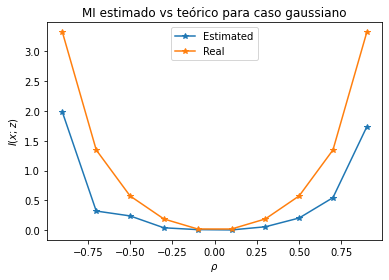

In [6]:
plt.figure()
plt.title('MI estimado vs teórico para caso gaussiano')
plt.plot(corr_factor,empirical_mi,'-*',label = 'Estimated')
plt.plot(corr_factor,theoretical_mi,'-*',label = 'Real')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$I(x;z)$')
plt.legend()
plt.show()